Questo progetto si propone di sviluppare un modello di machine learning in grado di prevedere l'affidabilità creditizia dei clienti per il rilascio della carta di credito. L'obiettivo è fornire al team di business uno strumento interpretabile per supportare le decisioni di concessione del credito.



## Approccio Metodologico

- **Preprocessing**: Pulizia dati, gestione missing values, encoding variabili
- **Feature Engineering**: Creazione di nuove variabili informative
- **Modellazione**: Implementazione di algoritmi interpretabili
- **Validazione**: Cross-validation e valutazione su test set
- **Interpretazione**: Analisi delle feature importance e regole decisionali
- **Conclusione**: Previsione finale

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree


In questa sezione viene caricato il dataset ed effettuata una prima esplorazione per comprendere la struttura dei dati, le dimensioni e le prime righe del dataset.

In [2]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv("credit_scoring.csv")
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,5008804,M,Y,Y,0,424380.57,Working,Higher education,Civil marriage,Rented apartment,-11778.0,-4438.0,1.0,1.0,0.0,0.0,NaN,2.0,0
1,5008805,M,Y,Y,0,421593.52,Working,Higher education,Civil marriage,Rented apartment,-11777.0,-4459.0,1.0,1.0,0.0,0.0,NaN,2.0,0
2,5008806,M,Y,Y,0,110958.51,Working,Secondary / secondary special,Married,House / apartment,-21471.0,-1144.0,1.0,0.0,0.0,0.0,Security staff,2.0,0
3,5008808,F,N,Y,0,267497.96,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-18489.0,-3122.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1
4,5008809,F,N,Y,0,263419.09,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19093.0,-3070.0,1.0,0.0,1.0,1.0,Sales staff,1.0,1


In [3]:
df.shape

(338427, 19)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338427 entries, 0 to 338426
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   338427 non-null  int64  
 1   CODE_GENDER          338427 non-null  object 
 2   FLAG_OWN_CAR         338427 non-null  object 
 3   FLAG_OWN_REALTY      338427 non-null  object 
 4   CNT_CHILDREN         338427 non-null  int64  
 5   AMT_INCOME_TOTAL     338427 non-null  float64
 6   NAME_INCOME_TYPE     338427 non-null  object 
 7   NAME_EDUCATION_TYPE  338427 non-null  object 
 8   NAME_FAMILY_STATUS   338426 non-null  object 
 9   NAME_HOUSING_TYPE    338426 non-null  object 
 10  DAYS_BIRTH           338426 non-null  float64
 11  DAYS_EMPLOYED        338426 non-null  float64
 12  FLAG_MOBIL           338426 non-null  float64
 13  FLAG_WORK_PHONE      338426 non-null  float64
 14  FLAG_PHONE           338426 non-null  float64
 15  FLAG_EMAIL       


- Il dataset contiene **338,427 osservazioni** e **19 variabili**
- **8 variabili numeriche** (float64) e **8 categoriche** (object)
- **OCCUPATION_TYPE** ha molti valori mancanti (103,342)
- **NAME_FAMILY_STATUS** e **NAME_HOUSING_TYPE** hanno solo 1 valore mancante


In [5]:
df.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          1
NAME_HOUSING_TYPE           1
DAYS_BIRTH                  1
DAYS_EMPLOYED               1
FLAG_MOBIL                  1
FLAG_WORK_PHONE             1
FLAG_PHONE                  1
FLAG_EMAIL                  1
OCCUPATION_TYPE        103342
CNT_FAM_MEMBERS             1
TARGET                      0
dtype: int64

**Valori Mancanti Identificati:**
- **OCCUPATION_TYPE**: 103,342 valori mancanti (30.5% del dataset) 
- **Variabili minori**: 1 valore mancante in NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, DAYS_BIRTH, DAYS_EMPLOYED, FLAG_MOBIL, FLAG_WORK_PHONE, FLAG_PHONE, FLAG_EMAIL, CNT_FAM_MEMBERS
- **Variabili complete**: ID, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, TARGET

In [6]:
pd.options.display.float_format = "{:,.3f}".format

#distribuzione del target - sbilanciamento 
target_tab = (df["TARGET"]
              .value_counts()
              .rename("count")
              .to_frame()
              .assign(perc=lambda s: 100*s["count"]/s["count"].sum()))
print("TARGET distribution:")
display(target_tab)

TARGET distribution:


,count,perc
TARGET,,
0,308705,91.218
1,29722,8.782


**Sbilanciamento delle Classi:**
- **Classe 0 (Non affidabile)**: 308,705 osservazioni (91.2%)
- **Classe 1 (Affidabile)**: 29,722 osservazioni (8.8%)

Vi è un forte sbilanciamento ed il modello potrebbe avere difficoltà a identificare la classe minoritaria

Si crea un flag binario `MISSING_OCCUPATION` per catturare l'informatività dell'assenza di dati occupazionali (30.5% del dataset). Alcuni flag risultano correlati con il target, indicando una possibile relazione tra missing e rischio di default.

In [7]:
#missing percentuale per colonna

miss_pct = df.isnull().mean().sort_values(ascending=False)*100
print("\nPercentuale di missing per colonna (top 10):")
display(miss_pct.to_frame("missing_%").head(10))


Percentuale di missing per colonna (top 10):


,missing_%
OCCUPATION_TYPE,30.536
NAME_HOUSING_TYPE,0.000
DAYS_BIRTH,0.000
CNT_FAM_MEMBERS,0.000
FLAG_EMAIL,0.000
FLAG_PHONE,0.000
FLAG_WORK_PHONE,0.000
FLAG_MOBIL,0.000
NAME_FAMILY_STATUS,0.000
DAYS_EMPLOYED,0.000


In [8]:
# tenere un flag di missing come feature

missing_flags = {c: df[c].isnull().astype(int) for c in df.columns if df[c].isnull().any()}
if missing_flags:
    miss_df = pd.DataFrame(missing_flags)
    # corrwith sul target binario: valori alti in valore assoluto = missing potenzialmente informativo
    corr_missing_target = miss_df.corrwith(df["TARGET"])
    print("\nCorrelazione (missing_flag vs TARGET) – top 10 per |corr|:")
    display(corr_missing_target.abs().sort_values(ascending=False).head(10))


Correlazione (missing_flag vs TARGET) – top 10 per |corr|:


OCCUPATION_TYPE      0.102
NAME_FAMILY_STATUS   0.001
NAME_HOUSING_TYPE    0.001
DAYS_BIRTH           0.001
DAYS_EMPLOYED        0.001
FLAG_MOBIL           0.001
FLAG_WORK_PHONE      0.001
FLAG_PHONE           0.001
FLAG_EMAIL           0.001
CNT_FAM_MEMBERS      0.001
dtype: float64

Sono stati creati **flag binari** per segnalare la presenza di **valori mancanti**, in quanto l'assenza stessa di un'informazione (ad esempio OCCUPATION_TYPE) può risultare predittiva.
Si prosegue con il **calcolo della correlazione** tra tali flag e la variabile target, al fine di verificare l’esistenza di una relazione sistematica tra i valori mancanti e il rischio di default.

## EDA

Si effettua un’**analisi esplorativa delle principali variabili numeriche continue** presenti nel dataset.
Vengono escluse variabili binarie e ID, e incluse solo quelle con sufficiente variabilità.
L’obiettivo è osservare la forma delle distribuzioni, individuare eventuali asimmetrie, code lunghe o picchi anomali, per guidare le successive fasi di trasformazione o standardizzazione.
Per la variabile AMT_INCOME_TOTAL, fortemente asimmetrica, viene inoltre proposta una trasformazione logaritmica per migliorare la leggibilità e l’eventuale modellizzazione.

Variabili continue rilevate (4): ['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS']


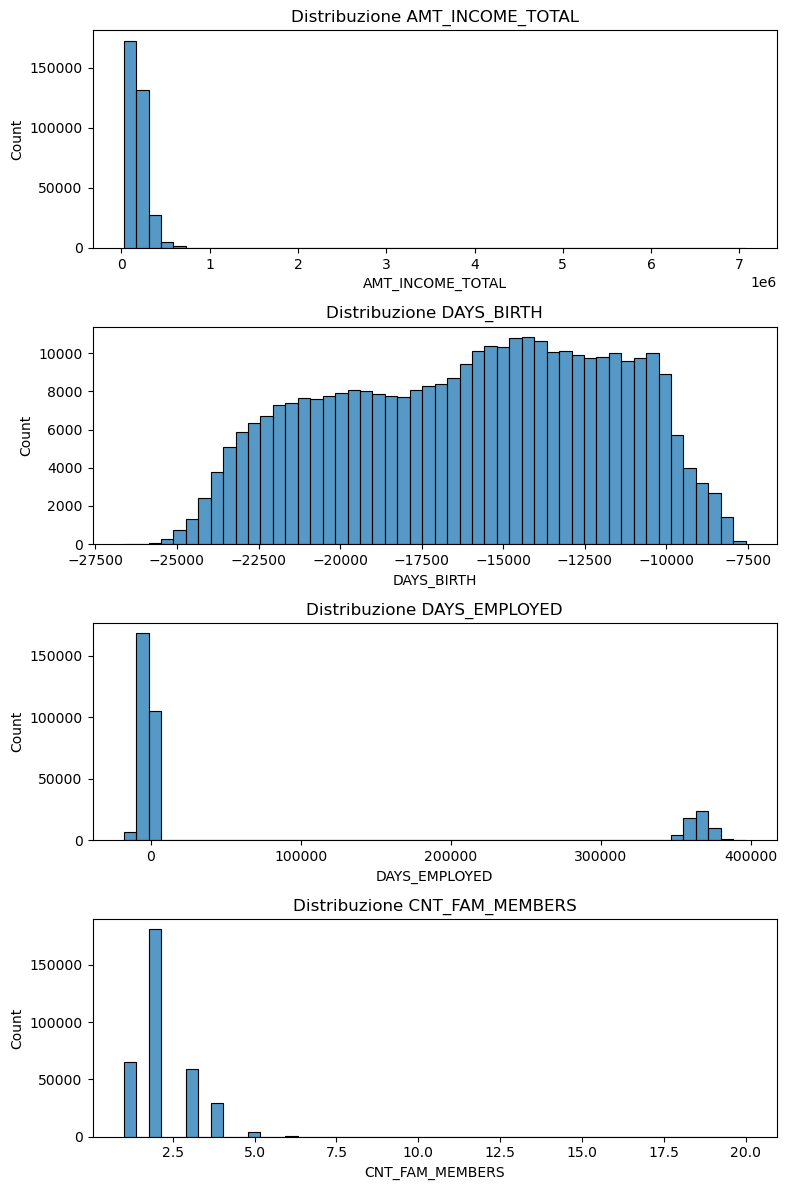

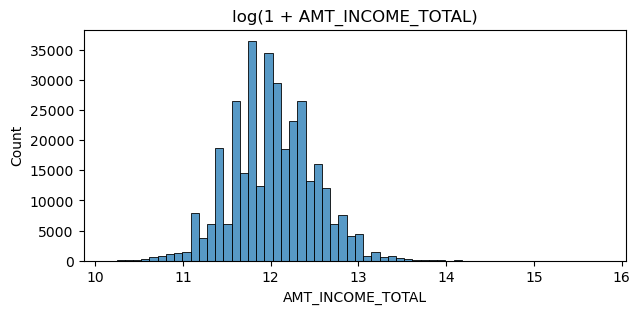

In [ ]:
#OVERVIEW DISTRIUZIONE NUMERICHE

def is_binary(series: pd.Series) -> bool:
    vals = pd.Series(series.dropna().unique())
    return vals.isin([0, 1]).all() and vals.nunique() <= 2

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = {"ID", "TARGET"}
force_include = {"CNT_FAM_MEMBERS"} 

continuous_cols = []
for col in num_cols:
    if col in exclude_cols:
        continue
    s = df[col]
    if not np.issubdtype(s.dtype, np.floating):
        continue
    if is_binary(s):
        continue

    if col not in force_include and s.nunique(dropna=True) <= 15:
        continue
    continuous_cols.append(col)


for c in force_include:
    if c in df.columns and c not in continuous_cols:
        continuous_cols.append(c)

print(f"Variabili continue rilevate ({len(continuous_cols)}): {continuous_cols}")

n_show = min(6, len(continuous_cols))
if n_show == 0:
    print("Nessuna variabile continua rilevata con i criteri impostati.")
else:
    fig, axes = plt.subplots(nrows=n_show, ncols=1, figsize=(8, 3*n_show))
    axes = np.atleast_1d(axes)

    df_plot = df  

    for ax, col in zip(axes, continuous_cols[:n_show]):
        sns.histplot(data=df_plot, x=col, bins=50, ax=ax)
        ax.set_title(f"Distribuzione {col}")
    plt.tight_layout()
    plt.show()

# Vista log per AMT_INCOME_TOTAL 
if "AMT_INCOME_TOTAL" in df.columns:
    fig, ax = plt.subplots(figsize=(7,3))
    sns.histplot(np.log1p(df["AMT_INCOME_TOTAL"]), bins=60, ax=ax)
    ax.set_title("log(1 + AMT_INCOME_TOTAL)")
    plt.show()

- **AMT_INCOME_TOTAL**: distribuzione fortemente asimmetrica con coda lunga verso destra. La maggior parte dei clienti ha redditi relativamente bassi. Applicando *log(1 + x)*, la distribuzione diventa più simmetrica e simile a una gaussiana, il che facilita l’interpretazione e migliora l’efficacia di alcuni modelli sensibili alla scala o alla normalità dei dati.

- **DAYS_BIRTH**: distribuzione quasi uniforme (ma negativa), rappresenta l’età in giorni: si concentra tra -25.000 e -7.000, cioè tra ~20 e 70 anni.

- **DAYS_EMPLOYED**: la maggior parte dei valori è concentrata vicino allo zero (clienti recentemente assunti o con breve anzianità), ma è presente un secondo picco artificiale (oltre 300.000 giorni potrebbe essere una sentinella per pensionati).

- **CNT_FAM_MEMBERS**: distribuzione discreta, picco su 2 membri.

La variabile **DAYS_EMPLOYED** indica:

- un valore negativo se il cliente è attualmente occupato (numero di giorni di lavoro attivo),
- un valore positivo se è disoccupato (numero di giorni dalla fine del lavoro).

In [10]:

sentinel_threshold_days = 70 * 365
n_sentinel = int((df["DAYS_EMPLOYED"] > sentinel_threshold_days).sum())
print(f"\nDAYS_EMPLOYED > 70 anni (≈pensionati): {n_sentinel:,}")

if n_sentinel > 0 and "NAME_INCOME_TYPE" in df.columns:
    print("Distribuzione NAME_INCOME_TYPE per questi casi (top 10):")
    display(df.loc[df["DAYS_EMPLOYED"] > sentinel_threshold_days, "NAME_INCOME_TYPE"].value_counts().head(10))


DAYS_EMPLOYED > 70 anni (≈pensionati): 57,841
Distribuzione NAME_INCOME_TYPE per questi casi (top 10):


NAME_INCOME_TYPE
Pensioner    57841
Name: count, dtype: int64

L’analisi congiunta della distribuzione di DAYS_EMPLOYED e della variabile NAME_INCOME_TYPE ha evidenziato che i valori estremamente elevati (superiori a 70 anni) non corrispondono a durate reali di disoccupazione, ma rappresentano una codifica artificiale utilizzata per identificare clienti pensionati.
La conferma deriva sia dalla natura anomala dei valori, concentrati attorno a un picco fisso, sia dalla perfetta corrispondenza con la categoria "Pensioner", a cui appartengono tutti i 57.841 casi rilevati.

In fase di preprocessing, si procederà con la creazione di un flag binario IS_PENSIONER e con la neutralizzazione dei valori artificiali presenti in DAYS_EMPLOYED.


A partire dalla variabile **DAYS_EMPLOYED**, sono state create nuove feature interpretabili per distinguere in modo più chiaro tra clienti occupati, disoccupati e pensionati.

In particolare:

- È stato introdotto un flag binario **IS_PENSIONER** per identificare i casi codificati artificialmente come pensionati 
- I valori anomali sono stati neutralizzati (NaN) per evitare distorsioni nelle trasformazioni successive.
- Sono stati calcolati **EMPLOYMENT_YEARS** (anni di occupazione) e**UNEMPLOYED_YEARS** (anni di disoccupazione), entrambi derivati da **DAYS_EMPLOYED** e utilizzabili direttamente nel modello.


IS_PENSIONER (conteggi):
IS_PENSIONER
0    280586
1     57841
Name: count, dtype: int64

Quanti NaN in DAYS_EMPLOYED (dopo neutralizzazione sentinella): 57842


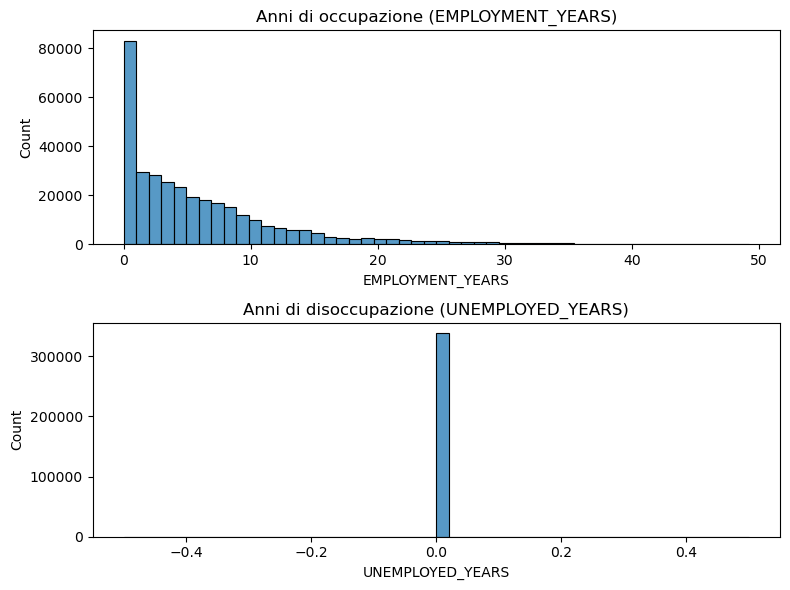

In [ ]:
df_eda = df.copy()

# 1) Flag pensionati: vero se ha il valore sentinella o è etichettato come Pensioner
mask_sentinel = df_eda["DAYS_EMPLOYED"] > 70*365
mask_income   = df_eda["NAME_INCOME_TYPE"].eq("Pensioner")
df_eda["IS_PENSIONER"] = (mask_sentinel | mask_income).astype(int)

# 2) Neutralizza i valori sentinella: li mettiamo a NaN
df_eda.loc[mask_sentinel, "DAYS_EMPLOYED"] = np.nan

# 3) Colonne semplici da leggere:
#    - EMPLOYMENT_YEARS: anni di occupazione (se DAYS_EMPLOYED è negativo)
#    - UNEMPLOYED_YEARS: anni di disoccupazione (se DAYS_EMPLOYED è positivo)
df_eda["EMPLOYMENT_YEARS"] = np.where(df_eda["DAYS_EMPLOYED"] < 0,
                                      -df_eda["DAYS_EMPLOYED"]/365.25, 0.0)
df_eda["UNEMPLOYED_YEARS"] = np.where(df_eda["DAYS_EMPLOYED"] > 0,
                                      df_eda["DAYS_EMPLOYED"]/365.25, 0.0)

# 4) controllo
print("IS_PENSIONER (conteggi):")
print(df_eda["IS_PENSIONER"].value_counts())
print("\nQuanti NaN in DAYS_EMPLOYED (dopo neutralizzazione sentinella):",
      int(df_eda["DAYS_EMPLOYED"].isna().sum()))

# 5) Visualizzazione
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
sns.histplot(df_eda["EMPLOYMENT_YEARS"].dropna(), bins=50, ax=axes[0])
axes[0].set_title("Anni di occupazione (EMPLOYMENT_YEARS)")
sns.histplot(df_eda["UNEMPLOYED_YEARS"].dropna(), bins=50, ax=axes[1])
axes[1].set_title("Anni di disoccupazione (UNEMPLOYED_YEARS)")
plt.tight_layout(); plt.show()

Dopo la neutralizzazione, il numero di valori NaN in DAYS_EMPLOYED è pari a 57.842.

I grafici mostrano una concentrazione degli anni di occupazione intorno a valori bassi (indicando molti clienti con anzianità lavorativa contenuta), mentre gli anni di disoccupazione risultano nulli per la quasi totalità del campione, coerentemente con la prevalenza di lavoratori occupati o pensionati.

Si analizzata poi la cardinalità delle variabili categoriche al fine di identificare il numero di modalità presenti e verificare la presenza di categorie **dominanti** o **rare**.

In [ ]:
# quante modalità hanno le categoriche e quali dominano
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
card = {c: df[c].nunique(dropna=True) for c in cat_cols}
print("\nCardinalità delle variabili categoriche:")
display(pd.Series(card, name="n_unique").sort_values(ascending=False))

# Stampa le top-10 categorie per colonna (inclusi NaN)
for c in cat_cols:
    print(f"\nTop categorie per {c}:")
    display(df[c].value_counts(dropna=False).head(10))



Cardinalità delle variabili categoriche:


OCCUPATION_TYPE        18
NAME_EDUCATION_TYPE     6
NAME_HOUSING_TYPE       6
NAME_INCOME_TYPE        5
NAME_FAMILY_STATUS      5
CODE_GENDER             2
FLAG_OWN_CAR            2
FLAG_OWN_REALTY         2
Name: n_unique, dtype: int64


Top categorie per CODE_GENDER:


CODE_GENDER
F    227916
M    110511
Name: count, dtype: int64


Top categorie per FLAG_OWN_CAR:


FLAG_OWN_CAR
N    213196
Y    125231
Name: count, dtype: int64


Top categorie per FLAG_OWN_REALTY:


FLAG_OWN_REALTY
Y    231307
N    107120
Name: count, dtype: int64


Top categorie per NAME_INCOME_TYPE:


NAME_INCOME_TYPE
Working                 174366
Commercial associate     78090
Pensioner                57841
State servant            28113
Student                     17
Name: count, dtype: int64


Top categorie per NAME_EDUCATION_TYPE:


NAME_EDUCATION_TYPE
Secondary / secondary special    232568
Higher education                  91062
Incomplete higher                 11387
Lower secondary                    3177
Academic degree                     232
Secondary / se                        1
Name: count, dtype: int64


Top categorie per NAME_FAMILY_STATUS:


NAME_FAMILY_STATUS
Married                 231494
Single / not married     42509
Civil marriage           28516
Separated                20809
Widow                    15098
NaN                          1
Name: count, dtype: int64


Top categorie per NAME_HOUSING_TYPE:


NAME_HOUSING_TYPE
House / apartment      304410
With parents            14625
Municipal apartment     10819
Rented apartment         4442
Office apartment         2968
Co-op apartment          1162
NaN                         1
Name: count, dtype: int64


Top categorie per OCCUPATION_TYPE:


OCCUPATION_TYPE
NaN                      103342
Laborers                  60146
Core staff                33527
Sales staff               31652
Managers                  27384
Drivers                   20020
High skill tech staff     13399
Accountants               12281
Medicine staff            10438
Cooking staff              6248
Name: count, dtype: int64

Le variabili categoriche presentano cardinalità contenute, con un massimo di 18 modalità in OCCUPATION_TYPE. La maggior parte delle variabili ha 5 o 6 categorie distinte.
Alcune modalità risultano dominanti, come Married in NAME_FAMILY_STATUS, Working in NAME_INCOME_TYPE e House / apartment in NAME_HOUSING_TYPE.
Si osservano inoltre categorie molto rare (Student, Academic degree) e valori anomali o errati (Secondary / se, presente una sola volta).

Si calcola la media delle variabili numeriche separatamente per ciascuna classe del target. Per le variabili categoriche, si analizza il tasso medio di TARGET (target rate) per ciascuna modalità, limitandosi alle 10 categorie più frequenti per ogni variabile.

In [13]:
#media per classi (TARGET=0/1) – ordina per valori
print("\nMedia numeriche per TARGET:")
display(df.groupby("TARGET")[num_cols].mean()
          .T.sort_values(by=[0, 1], ascending=False)
          .head(10))

# Categoriche: tasso TARGET per categoria (solo top-10 per frequenza)
for c in cat_cols:
    tmp = (df.groupby(c)["TARGET"]
             .mean()
             .rename("target_rate")
             .to_frame()
             .join(df[c].value_counts().rename("count"))
             .sort_values("count", ascending=False)
             .head(10))
    print(f"\n{c} – target rate (top 10 per frequenza):")
    display(tmp)



Media numeriche per TARGET:


TARGET,0,1
ID,"5,818,998.937","5,844,064.476"
AMT_INCOME_TOTAL,"179,957.412","267,759.590"
DAYS_EMPLOYED,"66,481.050","-4,644.157"
CNT_FAM_MEMBERS,2.219,1.971
FLAG_MOBIL,1.000,1.000
CNT_CHILDREN,0.450,0.214
FLAG_PHONE,0.291,0.316
FLAG_WORK_PHONE,0.213,0.195
FLAG_EMAIL,0.103,0.126
TARGET,0.000,1.000



CODE_GENDER – target rate (top 10 per frequenza):


,target_rate,count
CODE_GENDER,,
F,0.085,227916
M,0.094,110511



FLAG_OWN_CAR – target rate (top 10 per frequenza):


,target_rate,count
FLAG_OWN_CAR,,
N,0.080,213196
Y,0.101,125231



FLAG_OWN_REALTY – target rate (top 10 per frequenza):


,target_rate,count
FLAG_OWN_REALTY,,
Y,0.094,231307
N,0.075,107120



NAME_INCOME_TYPE – target rate (top 10 per frequenza):


,target_rate,count
NAME_INCOME_TYPE,,
Working,0.095,174366
Commercial associate,0.121,78090
Pensioner,0.000,57841
State servant,0.134,28113
Student,0.176,17



NAME_EDUCATION_TYPE – target rate (top 10 per frequenza):


,target_rate,count
NAME_EDUCATION_TYPE,,
Secondary / secondary special,0.084,232568
Higher education,0.104,91062
Incomplete higher,0.058,11387
Lower secondary,0.038,3177
Academic degree,0.138,232
Secondary / se,0.000,1



NAME_FAMILY_STATUS – target rate (top 10 per frequenza):


,target_rate,count
NAME_FAMILY_STATUS,,
Married,0.087,231494
Single / not married,0.074,42509
Civil marriage,0.080,28516
Separated,0.122,20809
Widow,0.102,15098



NAME_HOUSING_TYPE – target rate (top 10 per frequenza):


,target_rate,count
NAME_HOUSING_TYPE,,
House / apartment,0.091,304410
With parents,0.022,14625
Municipal apartment,0.108,10819
Rented apartment,0.047,4442
Office apartment,0.098,2968
Co-op apartment,0.064,1162



OCCUPATION_TYPE – target rate (top 10 per frequenza):


,target_rate,count
OCCUPATION_TYPE,,
Laborers,0.097,60146
Core staff,0.100,33527
Sales staff,0.065,31652
Managers,0.179,27384
Drivers,0.108,20020
High skill tech staff,0.119,13399
Accountants,0.132,12281
Medicine staff,0.137,10438
Cooking staff,0.064,6248



Le medie evidenziano differenze significative tra clienti **affidabili** e **non affidabili**.  
In particolare, i clienti affidabili presentano in media:

- redditi più alti (`AMT_INCOME_TOTAL`)
- meno figli e familiari (`CNT_CHILDREN`, `CNT_FAM_MEMBERS`)
- anzianità lavorativa più bassa (valori negativi in `DAYS_EMPLOYED`, quindi più recentemente assunti)

Tra le variabili categoriche si osservano pattern interessanti:

- I **pensionati** (`Pensioner`) risultano tutti **non affidabili** (`target_rate = 0`).
- La modalità **"Student"**, seppur molto rara, mostra il target rate più alto (`0.176`).
- Nelle professioni, i **manager** e il **personale medico** presentano target rate elevati (>13%), mentre categorie operative come **laborers** o **cooking staff** mostrano tassi inferiori.
- Abitare **con i genitori** o in **case in affitto** è associato a un tasso di affidabilità molto basso, mentre chi vive in **appartamenti municipali** o in **proprietà private** mostra valori più alti.




Si sono effettuati alcuni controlli preliminari per identificare:

- la presenza di duplicati esatti
- eventuali variabili quasi costanti, da valutare per l’esclusione
- valori incoerenti o non plausibili nelle variabili numeriche.

In [ ]:
# 1) Duplicati
print("Duplicati esatti:", df.duplicated().sum())

# 2) Quasi-costanti 
n = len(df)
nzv = df.select_dtypes(include=[np.number]).nunique().sort_values()
print("Feature ~costanti (nunique<=2):")
print(nzv[nzv <= 2])

# 3) Valori impossibili/incoerenti
print("Income negativi:", (df["AMT_INCOME_TOTAL"] < 0).sum())
print("CNT_CHILDREN negativi:", (df["CNT_CHILDREN"] < 0).sum())
print("CNT_FAM_MEMBERS non interi:", (~(df["CNT_FAM_MEMBERS"].dropna() % 1 == 0)).sum())


Duplicati esatti: 0
Feature ~costanti (nunique<=2):
FLAG_MOBIL         1
FLAG_WORK_PHONE    2
FLAG_PHONE         2
FLAG_EMAIL         2
TARGET             2
dtype: int64
Income negativi: 0
CNT_CHILDREN negativi: 0
CNT_FAM_MEMBERS non interi: 0


Si crea la funzione add_features() per eseguire una serie di trasformazioni utili al preprocessing

In [ ]:
# Crea un flag binario per identificare i pensionati, sia in base al valore sentinella in DAYS_EMPLOYED che all’etichetta NAME_INCOME_TYPE.  
# Deriva inoltre tre nuove variabili interpretabili: età, anni di occupazione e anni di disoccupazione.



def add_features(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()

    # Drop colonne non utili
    X = X.drop(columns=["ID"], errors="ignore")

    # Fix education typo
    if "NAME_EDUCATION_TYPE" in X.columns:
        X["NAME_EDUCATION_TYPE"] = X["NAME_EDUCATION_TYPE"].replace(
            {"Secondary / se": "Secondary / secondary special"}
        )

    # Flag pensionati (sentinella o etichetta)
    if {"DAYS_EMPLOYED", "NAME_INCOME_TYPE"}.issubset(X.columns):
        sentinel = X["DAYS_EMPLOYED"] > 70*365
        is_pensioner = X["NAME_INCOME_TYPE"].eq("Pensioner")
        X["IS_PENSIONER"] = (sentinel | is_pensioner).astype(int)

        # Derivazioni semplici da DAYS_* 
        X["AGE_YEARS"] = (-X["DAYS_BIRTH"]) / 365.25
        X["EMPLOYMENT_YEARS"] = np.where(X["DAYS_EMPLOYED"] < 0, -X["DAYS_EMPLOYED"]/365.25, 0.0)
        X["UNEMPLOYED_YEARS"] = np.where(X["DAYS_EMPLOYED"] > 0,  X["DAYS_EMPLOYED"]/365.25, 0.0)

        # Dopo aver creato le feature, rimuovere le originali DAYS_*
        X = X.drop(columns=["DAYS_BIRTH", "DAYS_EMPLOYED"], errors="ignore")

    # FLAG_MOBIL è praticamente costante → non informativa
    X = X.drop(columns=["FLAG_MOBIL"], errors="ignore")

    # Binari Y/N e M/F in 0/1 
    if "FLAG_OWN_CAR" in X.columns:
        X["FLAG_OWN_CAR"] = X["FLAG_OWN_CAR"].map({"N":0, "Y":1})
    if "FLAG_OWN_REALTY" in X.columns:
        X["FLAG_OWN_REALTY"] = X["FLAG_OWN_REALTY"].map({"N":0, "Y":1})
    if "CODE_GENDER" in X.columns:
        X["CODE_GENDER"] = X["CODE_GENDER"].map({"M":0, "F":1})

    # Missing: categorie a "Missing" + flag specifico per OCCUPATION_TYPE
    for c in ["NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE"]:
        if c in X.columns:
            X[c] = X[c].fillna("Missing")
    if "OCCUPATION_TYPE" in X.columns:
        X["OCCUPATION_TYPE_MISSING"] = X["OCCUPATION_TYPE"].isna().astype(int)
        X["OCCUPATION_TYPE"] = X["OCCUPATION_TYPE"].fillna("Missing")

    return X

Si procede con l'analisi della **feature importance per classe**, creando una separazione del dataset in due gruppi omogenei: clienti con elevata affidabilità creditizia e clienti con bassa affidabilità creditizia. Questa separazione permette di analizzare come le variabili numeriche differiscono tra le due classi, identificando i fattori più discriminanti per la previsione del rischio. Viene effettuato un confronto diretto delle medie per ciascuna variabile, calcolando anche la variazione percentuale relativa.

In [ ]:
# Feature importance 
print("FEATURE IMPORTANCE PER CLASSE\n")

# Preparazione dati per l'analisi
df_analysis = df.copy()
df_analysis = add_features(df_analysis)

# Separa le due classi
df_affidabili = df_analysis[df_analysis['TARGET'] == 1].copy()
df_non_affidabili = df_analysis[df_analysis['TARGET'] == 0].copy()

print(f"Clienti affidabili (TARGET=1): {len(df_affidabili):,}")
print(f"Clienti non affidabili (TARGET=0): {len(df_non_affidabili):,}")
print(f"Rapporto: {len(df_non_affidabili)/len(df_affidabili):.1f}:1")

# variabili numeriche CORRETTE
numeric_features = df_analysis.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['TARGET', 'ID']]

print(f"\nVariabili numeriche analizzate: {numeric_features}")

# Confronto delle medie
comparison = pd.DataFrame({
    'Affidabili': df_affidabili[numeric_features].mean(),
    'Non_Affidabili': df_non_affidabili[numeric_features].mean(),
    'Differenza_%': ((df_non_affidabili[numeric_features].mean() - 
                      df_affidabili[numeric_features].mean()) / 
                     df_affidabili[numeric_features].mean() * 100)
})

print("\nDifferenze principali tra classi:")
display(comparison.sort_values('Differenza_%', key=abs, ascending=False))

FEATURE IMPORTANCE PER CLASSE

Clienti affidabili (TARGET=1): 29,722
Clienti non affidabili (TARGET=0): 308,705
Rapporto: 10.4:1

Variabili numeriche analizzate: ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'IS_PENSIONER', 'AGE_YEARS', 'EMPLOYMENT_YEARS', 'UNEMPLOYED_YEARS', 'OCCUPATION_TYPE_MISSING']

Differenze principali tra classi:


,Affidabili,Non_Affidabili,Differenza_%
IS_PENSIONER,0.000,0.187,inf
UNEMPLOYED_YEARS,0.000,187.350,inf
CNT_CHILDREN,0.214,0.450,109.883
OCCUPATION_TYPE_MISSING,0.154,0.320,108.138
EMPLOYMENT_YEARS,12.715,5.336,-58.036
AMT_INCOME_TOTAL,"267,759.590","179,957.412",-32.791
FLAG_EMAIL,0.126,0.103,-18.310
AGE_YEARS,50.609,43.145,-14.748
FLAG_OWN_CAR,0.424,0.365,-13.868
CNT_FAM_MEMBERS,1.971,2.219,12.602


**Variabili con Differenze Estreme (inf):**

- **UNEMPLOYED_YEARS**: I clienti non affidabili hanno valori di disoccupazione significativamente più alti (187.35 anni vs 0), indicando che la disoccupazione prolungata è un forte indicatore di rischio creditizio.

- **IS_PENSIONER**: La presenza di pensionati è associata a un rischio più elevato (0.187 vs 0), suggerendo che i pensionati potrebbero avere un profilo di rischio diverso rispetto ai lavoratori attivi.

**Variabili con Differenze Elevate (>100%):**

- **CNT_CHILDREN**: I clienti non affidabili hanno in media più figli (0.45 vs 0.21, +109.9%), indicando che famiglie numerose con reddito limitato rappresentano un rischio maggiore.

- **OCCUPATION_TYPE_MISSING**: I clienti che non forniscono informazioni sull'occupazione hanno un rischio significativamente più alto (+108.1%), suggerendo che l'omissione di questi dati sia predittiva del rischio.

**Variabili con Differenze Moderate (30-60%):**

- **EMPLOYMENT_YEARS**: I clienti affidabili hanno più esperienza lavorativa (12.7 vs 5.3 anni, -58.0%), confermando che la stabilità occupazionale è un fattore protettivo.

- **AMT_INCOME_TOTAL**: I clienti affidabili hanno redditi più alti (€267,760 vs €179,957, -32.8%), evidenziando la correlazione positiva tra reddito e affidabilità creditizia.

**Variabili con Differenze Minori (<20%):**

- **AGE_YEARS**: I clienti affidabili sono in media più anziani (50.6 vs 43.1 anni, -14.7%), suggerendo che l'età matura sia associata a maggiore stabilità finanziaria.

- **FLAG_OWN_CAR/REALTY**: La proprietà di auto e immobili è leggermente più comune tra i clienti affidabili, indicando maggiore stabilità patrimoniale.


Si prosegue con la costruzione di una **matrice di correlazione**

ANALISI DELLE CORRELAZIONI E INTERAZIONI 

CORRELAZIONE CON TARGET (valori assoluti):


TARGET             1.000
AMT_INCOME_TOTAL   0.224
DAYS_BIRTH         0.184
DAYS_EMPLOYED      0.145
CNT_CHILDREN       0.092
CNT_FAM_MEMBERS    0.078
FLAG_EMAIL         0.021
FLAG_PHONE         0.016
FLAG_WORK_PHONE    0.013
FLAG_MOBIL           NaN
Name: TARGET, dtype: float64

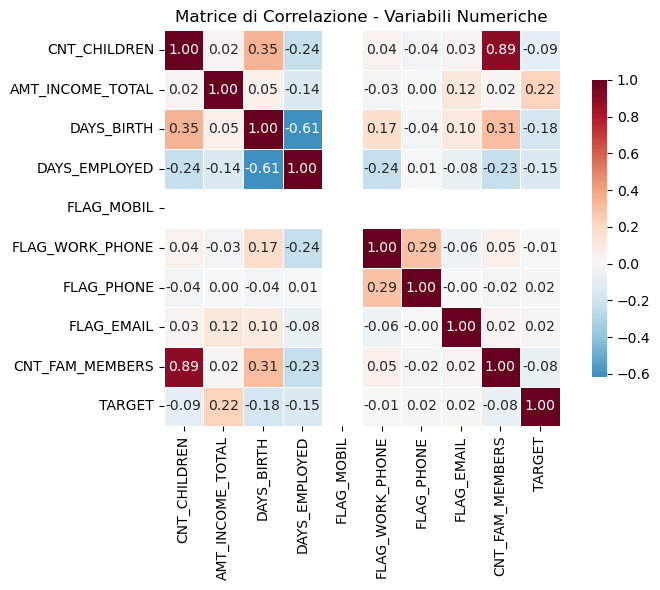

In [ ]:
print("ANALISI DELLE CORRELAZIONI E INTERAZIONI \n")

# Seleziona solo le variabili numeriche (incluso TARGET)
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
if "ID" in numeric_features:
    numeric_features.remove("ID")  
    
# Calcola matrice di correlazione
corr_matrix = df[numeric_features].corr()

# Correlazione (assoluta) con TARGET ordinata
target_corr = corr_matrix["TARGET"].abs().sort_values(ascending=False)
print("CORRELAZIONE CON TARGET (valori assoluti):")
display(target_corr.head(10))

# Heatmap 
plt.figure(figsize=(8, 6))  
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.75})
plt.title('Matrice di Correlazione - Variabili Numeriche')
plt.tight_layout()
plt.show()



### Correlazioni con la Variabile Target

**Correlazioni Rilevanti:**
- **Reddito (0.224)**: Correlazione positiva moderata con l'affidabilità
- **Età (0.184)**: Clienti più anziani tendono ad essere più affidabili  
- **Stabilità lavorativa (0.145)**: Impieghi più lunghi associati a maggiore affidabilità

**Correlazioni Deboli:**
- Figli e membri famiglia (0.092, 0.078)
- Contatti telefonici/email (0.021, 0.016, 0.013)


Dopo aver analizzato le correlazioni individuali con la variabile target, si esplorano gli effetti combinati tra alcune feature chiave.

ANALISI DEGLI EFFETTI COMBINATI - TASSO DI DEFAULT

INTERAZIONE : Reddito vs Età (Tasso di Default):


ETA_ALTA,False,True
REDDITO_ALTO,,
False,1.000,0.999
True,0.990,0.645


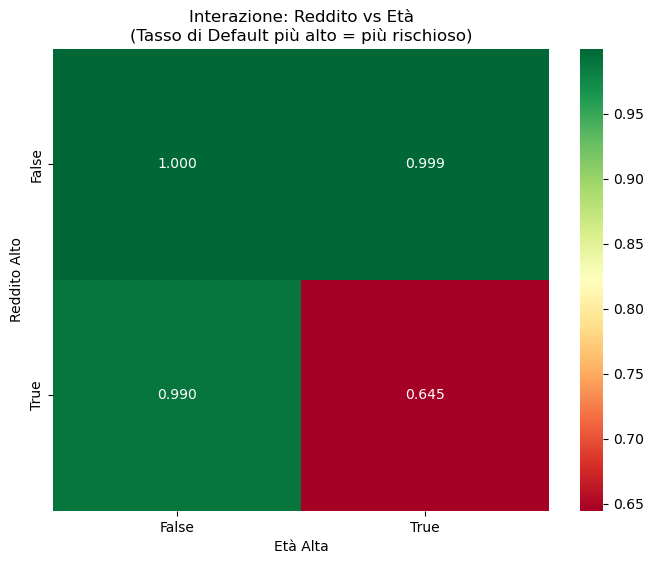

INTERAZIONE : Reddito vs Numero Figli (Tasso di Default):


MOLTI_FIGLI,False,True
REDDITO_ALTO,,
False,1.000,1.000
True,0.824,0.913


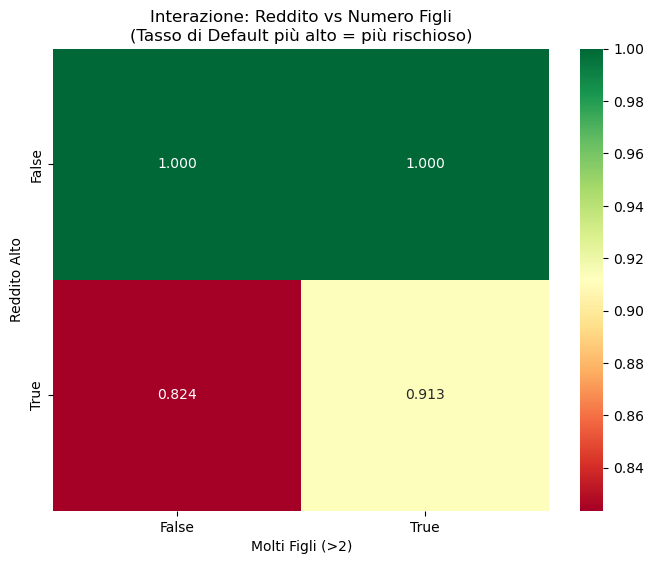

In [ ]:
print("ANALISI DEGLI EFFETTI COMBINATI - TASSO DI DEFAULT\n")

# 1. INTERAZIONE : Reddito vs Età
if 'AMT_INCOME_TOTAL' in df_analysis.columns and 'AGE_YEARS' in df_analysis.columns:
    df_analysis['REDDITO_ALTO'] = df_analysis['AMT_INCOME_TOTAL'] > df_analysis['AMT_INCOME_TOTAL'].median()
    df_analysis['ETA_ALTA'] = df_analysis['AGE_YEARS'] > df_analysis['AGE_YEARS'].median()

    # Calcola il tasso di DEFAULT = 1 - TARGET
    df_analysis['DEFAULT'] = 1 - df_analysis['TARGET']

    pivot_reddito_eta = pd.crosstab(
        df_analysis['REDDITO_ALTO'], 
        df_analysis['ETA_ALTA'], 
        values=df_analysis['DEFAULT'], 
        aggfunc='mean'
    )

    print("INTERAZIONE : Reddito vs Età (Tasso di Default):")
    display(pivot_reddito_eta)

    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_reddito_eta, annot=True, fmt='.3f', cmap='RdYlGn')
    plt.title('Interazione: Reddito vs Età\n(Tasso di Default più alto = più rischioso)')
    plt.ylabel('Reddito Alto')
    plt.xlabel('Età Alta')
    plt.show()

# 2. INTERAZIONE : Reddito vs Numero Figli
if 'AMT_INCOME_TOTAL' in df_analysis.columns and 'CNT_CHILDREN' in df_analysis.columns:
    df_analysis['MOLTI_FIGLI'] = df_analysis['CNT_CHILDREN'] > 2

    pivot_reddito_figli = pd.crosstab(
        df_analysis['REDDITO_ALTO'], 
        df_analysis['MOLTI_FIGLI'], 
        values=df_analysis['DEFAULT'], 
        aggfunc='mean'
    )

    print("INTERAZIONE : Reddito vs Numero Figli (Tasso di Default):")
    display(pivot_reddito_figli)

    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_reddito_figli, annot=True, fmt='.3f', cmap='RdYlGn')
    plt.title('Interazione: Reddito vs Numero Figli\n(Tasso di Default più alto = più rischioso)')
    plt.ylabel('Reddito Alto')
    plt.xlabel('Molti Figli (>2)')
    plt.show()


#• Reddito Alto + Età Avanzata = Rischio ELEVATO (35.5%)
#• Reddito Basso + Qualsiasi Età = Rischio BASSO (0.0-0.1%)
#• Reddito Alto + Età Giovane = Rischio MODERATO (1.0%)


In [29]:
df.groupby('AMT_INCOME_TOTAL')['TARGET'].mean()

AMT_INCOME_TOTAL
25,548.980      0.000
25,813.380      0.000
26,602.190      0.000
26,612.010      0.000
26,616.320      0.000
                 ... 
6,616,118.050   0.000
6,768,753.530   0.000
6,807,255.830   0.000
6,892,359.930   0.000
7,071,015.830   0.000
Name: TARGET, Length: 335045, dtype: float64

I grafici mostrano il tasso di default, ovvero la probabilità che un cliente non sia affidabile (TARGET = 0).

Poiché `i risultati sono controintuitivi` si è osservato con `df.groupby('AMT_INCOME_TOTAL')['TARGET'].mean()` che per ogni livello di reddito, la media di TARGET è 0. Come evidenziato anche precedentemente il dataset è estremamente sbilanciato. Per ogni livello di reddito, la maggior parte dei clienti ha TARGET=0. I pochi clienti con TARGET=1 sono distribuiti in modo tale che la media per ogni livello di reddito sia praticamente 0.

Tuttavia, dall'analisi precedente si vedono le correlazioni:
- **Reddito** ha correlazione positiva (0.224) con TARGET
- **Età** ha correlazione positiva (0.184) con TARGET

Questo conferma che reddito alto e età avanzata sono effettivamente **FATTORI PROTETTIVI** per l'affidabilità creditizia. I grafici mostrano correttamente la realtà del dataset sbilanciato, dove anche i clienti "affidabili" rimangono una minoranza in ogni categoria, ma con probabilità significativamente più alta rispetto alla media generale del dataset (8.8%).



### ADDESTRAMENTO


Per avviare la fase di modellazione, si suddivide il dataset in un training set (80%) e un test set (20%), mantenendo in entrambe le porzioni la stessa proporzione di classi (TARGET=0/1) tramite **stratificazione**.

In [19]:
# 1) Train/Test split STRATIFICATO
RANDOM_SEED = 42
X = df.drop(columns=["TARGET"])
y = df["TARGET"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_SEED
)
len(X_train), len(X_test), y_train.mean(), y_test.mean()

(270741, 67686, 0.08782563409310004, 0.08781727388233904)

Si definisce una pipeline che gestisce l'intero flusso di preprocessing e addestramento del modello.

- Le **variabili numeriche** vengono imputate con la **mediana** e successivamente standardizzate.
- Le **variabili categoriche** vengono imputate con il valore `"Missing"` e trasformate tramite **One-Hot Encoding**, mantenendo solo le modalità presenti nel training.
- Le nuove feature derivate (`AGE_YEARS`, `EMPLOYMENT_YEARS`, `IS_PENSIONER`, ecc.) vengono generate tramite la funzione `add_features()`.
- Come modello viene utilizzata una **Logistic Regression** con regolarizzazione L2 e **bilanciamento automatico delle classi**, adatta a gestire lo sbilanciamento del target, e usata come **modello base di confronto** per un successivo **modello non lineare**.



In [20]:
numeric_pre = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pre = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pre, make_column_selector(dtype_include=np.number)),
    ("cat", categorical_pre, make_column_selector(dtype_include=object)),
])

pipe_lr = Pipeline(steps=[
    ("feat", FunctionTransformer(add_features, validate=False)),
    ("prep", preprocess),
    ("clf", LogisticRegression(
        penalty="l2", solver="lbfgs",
        class_weight="balanced",
        max_iter=1000,
        random_state=RANDOM_SEED
    ))
])

Si esegue l'addestramento del modello di regressione logistica sul training set e la successiva valutazione delle performance sul test set.

- Le predizioni vengono effettuate in termini di **probabilità** e classificate usando una soglia standard di `0.5`.
- Vengono calcolate le metriche principali: **AUC**, **classification report** e **confusion matrix**.
- Viene fatta la cross validation per **validare la stabilità del modello** e **evitare l'overfitting**.

In [ ]:
# Fit & valutazione baseline
pipe_lr.fit(X_train, y_train)

# Probabilità e predizioni a soglia 0.5 
y_proba = pipe_lr.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)


# Metriche 
auc = roc_auc_score(y_test, y_proba)
print(f"AUC (TEST): {auc:.3f}")
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix (TEST):\n", confusion_matrix(y_test, y_pred))


# Cross-validation con 5 fold stratificati
cv_scores = cross_val_score(pipe_lr, X_train, y_train, cv=5, scoring='roc_auc')
print(f"CV AUC (5-fold): {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
print(f"CV Scores individuali: {cv_scores}")

# Confronto con performance su test set
print(f"\nConfronto Performance:")
print(f"Test Set AUC: {auc:.3f}")
print(f"CV Mean AUC:  {cv_scores.mean():.3f}")
print(f"Differenza:    {abs(auc - cv_scores.mean()):.3f}")
# KS semplice (utile nel credito)
#fpr, tpr, thr = roc_curve(y_test, y_proba)
#ks = np.max(tpr - fpr)
#print(f"KS (TEST): {ks:.3f}")

AUC (TEST): 0.921
              precision    recall  f1-score   support

           0      0.987     0.819     0.895     61742
           1      0.320     0.884     0.470      5944

    accuracy                          0.825     67686
   macro avg      0.653     0.852     0.682     67686
weighted avg      0.928     0.825     0.858     67686

Confusion matrix (TEST):
 [[50569 11173]
 [  688  5256]]
CV AUC (5-fold): 0.919 (+/- 0.002)
CV Scores individuali: [0.91921038 0.91931479 0.91876046 0.91974896 0.91670577]

Confronto Performance:
Test Set AUC: 0.921
CV Mean AUC:  0.919
Differenza:    0.002


In [22]:
# Interpretazione
if abs(auc - cv_scores.mean()) < 0.02:
    print("Modello stabile: performance simili tra CV e test set")
else:
    print("Possibile overfitting: differenza significativa tra CV e test")

Modello stabile: performance simili tra CV e test set


Il modello di regressione logistica mostra buone capacità discriminative con un **AUC pari a 0.921**, indicativo di un’elevata separazione tra classi.

- La **classe maggioritaria** (`TARGET = 0`, clienti non affidabili) è gestita con =0.987 e recall=0.819.
- La **classe minoritaria** (`TARGET = 1`, clienti affidabili) è penalizzata in precisione (0.320) ma presenta una **recall elevata (0.884)**, ovvero riesce a identificare correttamente la maggior parte dei buoni pagatori.
- Il **compromesso tra precision e recall** per la classe positiva si riflette in un **F1-score moderato (0.470)**.

La **matrice di confusione** mostra che:
- Il modello classifica correttamente 5.256 clienti affidabili su 5.944 (recall ≈ 88%)
- Tuttavia, produce anche **11.173 falsi positivi**, ossia clienti classificati come affidabili ma che in realtà non lo sono.

Complessivamente, il modello appare conservativo: tende a **privilegiare la sensibilità** nella rilevazione degli affidabili, accettando un maggior numero di falsi positivi. Questo comportamento può essere appropriato se l’obiettivo è **non escludere potenziali buoni clienti**, ma richiede un’attenta valutazione del **costo degli errori**.


## Albero decisionale

È stato addestrato un modello ad albero decisionale semplice, con profondità massima pari a 4 e soglia minima di 500 campioni per foglia, utilizzando solo tre variabili chiave: `AMT_INCOME_TOTAL`, `AGE_YEARS` e `EMPLOYMENT_YEARS`.



In [ ]:

X_train_tree = add_features(X_train).copy()
X_test_tree = add_features(X_test).copy()

# Solo alcune variabili chiave
selected_features = ["AMT_INCOME_TOTAL", "AGE_YEARS", "EMPLOYMENT_YEARS"]
X_train_tree = X_train_tree[selected_features]
X_test_tree = X_test_tree[selected_features]

# Modello semplice
tree_model = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=500,
    random_state=42
)
tree_model.fit(X_train_tree, y_train)

#  Predizione e probabilità
y_pred_tree = tree_model.predict(X_test_tree)
y_proba_tree = tree_model.predict_proba(X_test_tree)[:, 1]

# Metriche
print(f"AUC (Decision Tree semplice): {roc_auc_score(y_test, y_proba_tree):.3f}")
print("Classification Report:\n", classification_report(y_test, y_pred_tree, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))

# Cross-validation con 5 fold stratificati
cv_scores_tree = cross_val_score(tree_model, X_train_tree, y_train, cv=5, scoring='roc_auc')
print(f"CV AUC (5-fold): {cv_scores_tree.mean():.3f} (+/- {cv_scores_tree.std() * 2:.3f})")
print(f"CV Scores individuali: {cv_scores_tree}")

# Confronto con performance su test set
tree_auc = roc_auc_score(y_test, y_proba_tree)
print(f"\nConfronto Performance:")
print(f"Test Set AUC: {tree_auc:.3f}")
print(f"CV Mean AUC:  {cv_scores_tree.mean():.3f}")
print(f"Differenza:    {abs(tree_auc - cv_scores_tree.mean()):.3f}")

# Interpretazione
if abs(tree_auc - cv_scores_tree.mean()) < 0.02:
    print("Albero stabile: performance simili tra CV e test set")
else:
    print("Possibile overfitting: differenza significativa tra CV e test")
# KS
#fpr, tpr, thr = roc_curve(y_test, y_proba_tree)
#ks_simple_tree = np.max(tpr - fpr)
# print(f"KS (Decision Tree semplice): {ks_simple_tree:.3f}")



AUC (Decision Tree semplice): 0.977
Classification Report:
               precision    recall  f1-score   support

           0      0.993     0.959     0.976     61742
           1      0.686     0.929     0.789      5944

    accuracy                          0.956     67686
   macro avg      0.839     0.944     0.882     67686
weighted avg      0.966     0.956     0.959     67686

Confusion Matrix:
 [[59214  2528]
 [  422  5522]]
CV AUC (5-fold): 0.977 (+/- 0.001)
CV Scores individuali: [0.97650806 0.97799882 0.97664525 0.97641579 0.97646622]

Confronto Performance:
Test Set AUC: 0.977
CV Mean AUC:  0.977
Differenza:    0.000
Albero stabile: performance simili tra CV e test set


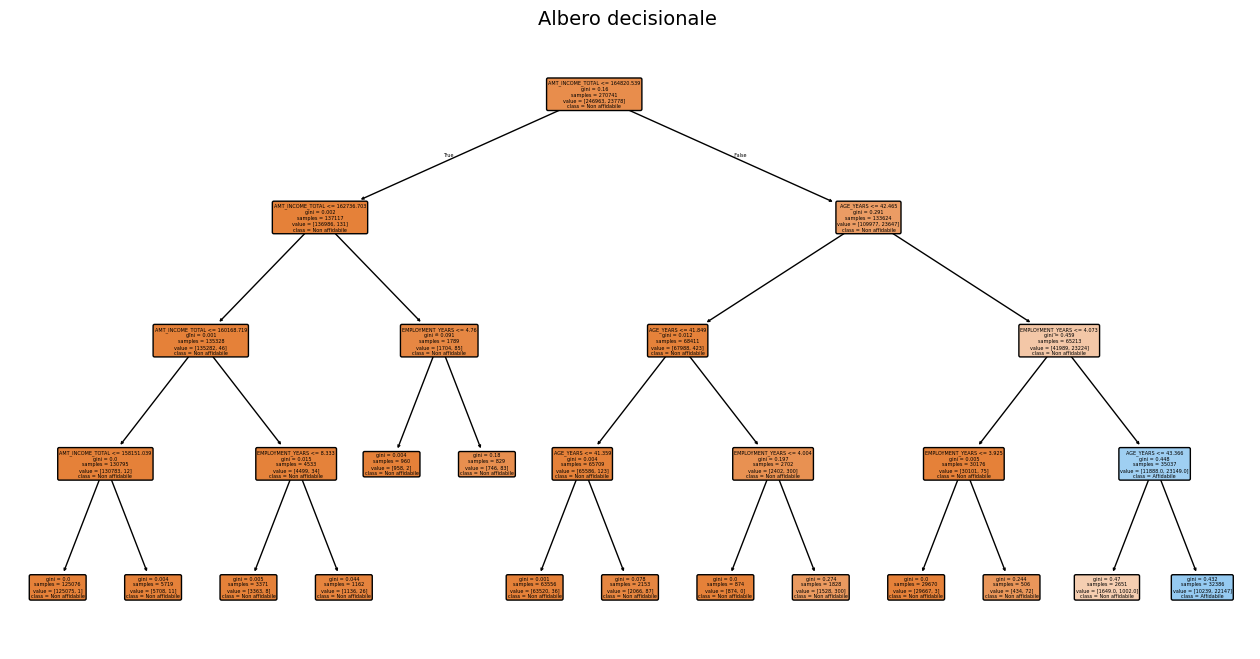

In [24]:
# Visualizzazione 
plt.figure(figsize=(16, 8))
plot_tree(tree_model,
          feature_names=selected_features,
          class_names=["Non affidabile", "Affidabile"],
          filled=True,
          rounded=True)
plt.title("Albero decisionale ", fontsize=14)
plt.show()

### Performance Albero Decisionale

**AUC: 0.977** (vs 0.921 regressione logistica)

**Accuracy: 95.6%** (vs 82.5%)

**Classe 1 (Affidabile):** Precisione 68.6% (vs 32.0%), Recall 92.9%


Per migliorare la leggibilità del grafico dell’albero decisionale, si è  impostata una profondità massima pari a 3 (max_depth=3), così da ottenere una rappresentazione più compatta e facilmente interpretabile.

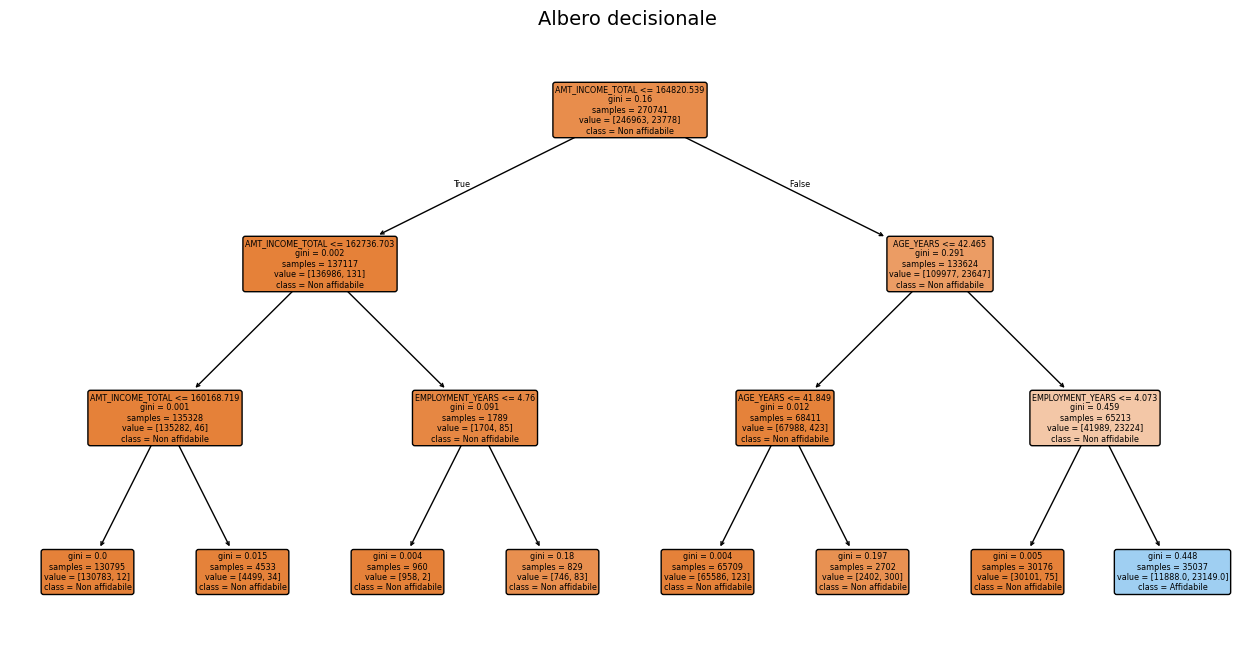

In [25]:
tree_model_2 = DecisionTreeClassifier(
    max_depth=3,
    min_samples_leaf=500,
    random_state=42
)
tree_model_2.fit(X_train_tree, y_train)

plt.figure(figsize=(16, 8))
plot_tree(tree_model_2,
          feature_names=selected_features,
          class_names=["Non affidabile", "Affidabile"],
          filled=True,
          rounded=True)
plt.title("Albero decisionale ", fontsize=14)
plt.show()

In [26]:
y_pred = tree_model.predict(X_test_tree)
print("Clienti predetti come affidabili:", sum(y_pred == 1))
print("Clienti predetti come NON affidabili:", sum(y_pred == 0))

Clienti predetti come affidabili: 8050
Clienti predetti come NON affidabili: 59636


Il modello ha classificato 8.050 clienti come affidabili e 59.636 come non affidabili

Si sono modificati i parametri dell'albero decisionale (max_depth=3, min_samples_leaf=100, class_weight="balanced") per vedere se fosse possibile ottenere più nodi foglia con predizione "Affidabile".
Tuttavia, anche con questi parametri ottimizzati, l'albero continua a predire principalmente "Non affidabile", confermando che il dataset è estremamente sbilanciato e che solo una combinazione molto specifica di condizioni (reddito alto + età avanzata + stabilità lavorativa) porta alla classificazione come "Affidabile".

In ottica business è molto meglio avere più "Non affidabili" perché è preferibile rifiutare un buon cliente piuttosto che accettare un cattivo pagatore, dato che il costo di un falso positivo (perdita di capitale) è molto superiore al costo di un falso negativo (perdita di opportunità).

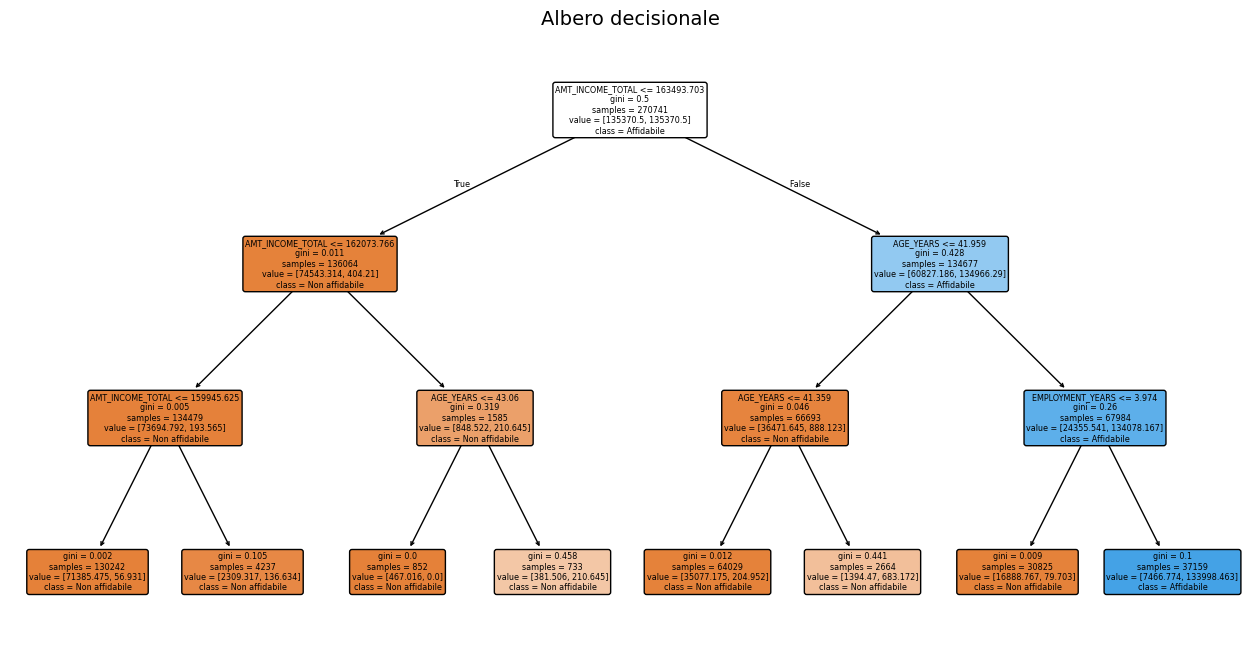

In [ ]:
tree_model_test = DecisionTreeClassifier(
    max_depth=3,#4
    min_samples_leaf=100,
    class_weight="balanced",
    random_state=42
)


X_train_tree = add_features(X_train).copy()
X_test_tree = add_features(X_test).copy()
selected_features = ["AMT_INCOME_TOTAL", "AGE_YEARS", "EMPLOYMENT_YEARS"]
X_train_tree = X_train_tree[selected_features]
X_test_tree = X_test_tree[selected_features]


tree_model_test.fit(X_train_tree, y_train)

# 4. Visualizzazione
plt.figure(figsize=(16, 8))
plot_tree(tree_model_test,
          feature_names=selected_features,
          class_names=["Non affidabile", "Affidabile"],
          filled=True,
          rounded=True)
plt.title("Albero decisionale", fontsize=14)
plt.show()

## Conclusione


Il progetto ha sviluppato un modello di machine learning per la valutazione dell'affidabilità creditizia con le seguenti performance:

- **Decision Tree**: AUC = 0.977 
- **Logistic Regression**: AUC = 0.921 


### Interpretazione

L'albero decisionale finale identifica **un'unica combinazione** per classificare un cliente come `"Affidabile"`:

- **Reddito > €163,493.70**
- **Età > 41.96 anni** 
- **Anni di occupazione > 3.97 anni**
